# UF Research Computing  

![UF Research Computing Logo](images/ufrc_logo.png)


This tutorial is adapted from: [Understanding PyTorch with an example: a step-by-step tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e) by Daniel Godoy.

This tutorial was adapted for UF Resarch Computing by Matt Gitzendanner.

## Introduction

**PyTorch** is one of the most widely used and fastest growing Deep Learning framworks. It is *pythonic*, meaning that it will feel familar to Python developers.

I came across Daniel's post while looking for good tutorials and very much like the approach he takes in starting with a **simple problem**, a **linear regression**, fleshing that out with NumPy code and then walking through, step-by-step the parts that can be facilitated with Pytorch. As Daniel states, this provides a "**structured**, **incremental** and **from first principles**" approach to Deep Learning.

I have converted Daniel's post to **Jupyeter notebooks** and broken the long post into several notebooks. I find Jupyter a good mehtod of playing with code. The notebooks can be run on [**HiPerGator**](https://jupyterhub.rc.ufl.edu/) (must be on UF network), [**Google Colaboratory**](https://colab.research.google.com/notebooks/), or elsewhere. While some steps will use a **GPU if present**, they should work in CPU. The example used is actually probably **slower to run on GPU**, but the idea is to give you the skills to move things in an out of GPUs when available.

## A simple regression problem

To focus on the goal of understanding how **PyTorch works**, Daniel Godoy sticks with a simple, familiar problem of linear regression with a single feature *x*.

>   *y = a + bx + &epsilon;*

## Data Generation

We begin generating some random data. Let's create a vector of 100 points for our **feature *x*** and our **labels** ***a=1, b=2***, adding some Gaussian noise.

Then we can split the made up, or *synthetic*, data into **train** and **test**, or **validation**, sets. 

In [1]:
import random
import numpy as np

# Data Generation
np.random.seed(42) # Comment out for random results.
x = np.random.rand(100, 1)

# y = 1 + 2x + Gaussian noise
y = 1 + 2 * x + .1 * np.random.randn(100, 1)


# Shuffles the indices to split train and validation datasets
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]

# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# Note these data are used in the other notebooks, so I have placed a slightly
# modified version of this cell into the file 'generate_data.py' to make
# it easy to recreate the data as you move from one notebook to the next.

(1.0, 3.0)

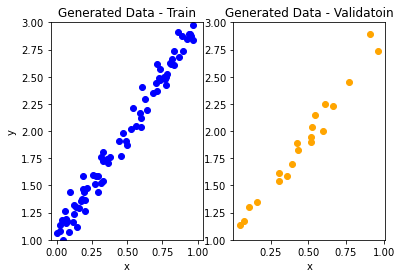

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the test and train datasets
fig, ax = plt.subplots(1,2)

ax[0].scatter(x_train,y_train, color='blue')
ax[0].set_title('Generated Data - Train')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_ylim(1,3) #May need to adjust if seed not set.

ax[1].scatter(x_val,y_val, color='orange')
ax[1].set_title('Generated Data - Validatoin')
ax[1].set_xlabel('x')
ax[1].set_ylim(1,3)

Since we make the data, we **know** that a=1 and b=2, but let's see how close we can get to the true values using **gradient descent** and the **training data** (80 randomly selected data values).

## Gradient Descent

In this section, Daniel outlines the **four basic staps** for **gradient descent**:
1. Compute the loss
1. Compute the gradients
1. Update the parameters (also known as weights)
1. Repeate the process

### Step 1: Compute the loss

For a regrssion problem, the **loss** function used is the **Mean square error (MSE)**. MSE is the average of all squared differences between **labels** (*y*) and **predictions** (*a + bx*).

Daniel Gody notes that:
> It is worth mentioning that, if we use **all points** in the training set (N) to compute the loss, we are performing a **batch** gradient descent. If we were to use a **single point** at each time, it would be a **stochastic** gradient descent. Anything else (n) **in-between 1 and N** characterizes a **mini-batch** gradient descent.

The formula for MSE is:

\begin{equation*}
MSE = \frac{1}{N}\sum_{i=1}^N ( y_i - \hat{y_i} )^2
\end{equation*}

Or, the mean of the squared differences between the observed ($y_i$) and predicted ($\hat{y_i}$) values. And since we made the data, we also know that the predicted values can be substituted with $a-bx_i$:

\begin{equation*}
MSE = \frac{1}{N}\sum_{i=1}^N ( y_i - a - bx_i )^2
\end{equation*}

### Step 2: Compute the gratients

A **gradient** is a **partial derivative** because it is computed with respect to (w.r.t.) a **single parameter**. We have two parameters, **a** and **b**, so we must compute two partial derivatives.

A **derivative** tells you *how much* **a given quantity changes** when you *slightly vary* some **other quantity**. In our case, how much does our **MSE loss** change when we vary **each one of our two parameters**?

The *right-most* part of the equations below is what you usually see in implementations of gradient descent for a simple linear regression. In the **intermediate steps**, Daniel Gody shows you **all elements** that pop-up from the applications of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), so you can know how the final expression came to be.

\begin{equation*}
\frac{\partial{MSE}}{\partial{a}} =
\frac{\partial{MSE}}{\partial{\hat{y_i}}} 
\cdot \frac{\partial{\hat{y_i}}} {\partial{a}} =
\frac{1}{N}\sum_{i=1}^N 2( y_i - a - bx_i ) \cdot (-1) =
-2\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y_i})
\end{equation*}

\begin{equation*}
\frac{\partial{MSE}}{\partial{b}} =
\frac{\partial{MSE}}{\partial{\hat{y_i}}} 
\cdot \frac{\partial{\hat{y_i}}} {\partial{ab}} =
\frac{1}{N}\sum_{i=1}^N 2( y_i - a - bx_i ) \cdot (-x_i) =
-2\frac{1}{N}\sum_{i=1}^Nx_i(y_i - \hat{y_i})
\end{equation*}

### Step 3: Update the parameters

In the final step, we **use the gradients to update** the parameters. Since we are trying to **minimize** our **losses**, we **reverse the sign** of the gradient for the update.

There is still another parameter to consider: the **learning rate**, denoted by the *Greek letter **eta** (**&eta;**)*, which is the **multiplicative factor** that we need to apply to the gradient for the parameter update.

\begin{equation*}
a = a - \eta\frac{\partial{MSE}}{\partial{a}}
\end{equation*}

\begin{equation*}
b = b-\eta\frac{\partial{MSE}}{\partial{b}}
\end{equation*}

Choosing a learning rate is beyond the scope of this tutorial.

### Step 4: Rinse and repeate!

Now we use the **updated parameters** to go back to **step 1** and restart the process.

>An **epoch is complete whenever every point has been already used for computing the loss**. For **batch** gradient descent, this is trivial, as it uses all points for computing the loss — **one epoch** is the same as **one update**. For **stochastic** gradient descent, **one epoch** means **N updates**, while for **mini-batch** (*of size n*), **one epoch** has **N/n updates**.

Repeating this process over and over, for **many epochs**, is, in a nutshell, **training** a model.

## Linear Regression in Numpy

Similar to the [Image Classification training module](https://github.com/UFResearchComputing/DL_pytorch_CNN) to understand what PyTorch is doing, we will first implement the linear regression model using gradient descent in Numpy only. Once that is understood, we can move on.

For training a model, we have two steps:
1. Random intialization of parameters, or **weights** (we have only two parameters, *a* and *b*).
1. Intialization of **hyper-parameters** (in our case, only the *learning rate* and *number of epochs*)  

In general, you always want to ensur randomization of the seed. The use of 42 for a seed in these examples ensures repeatability, but is *not* what you would want in real use.

**For each epoch**, we conduct the 4 steps:
1. Compute the model's predictions -- this is the **forward pass**
1. Compute the loss, using *predictions*, *labels* and the **loss function** for the task at hand
1. Compute the **gradients** for every parameter.
1. Update the parameters using our **learning rate**.


Keep in mind that, if you don’t use **batch gradient descent** (our example does),you’ll have to write an inner loop to perform the four training steps for either each individual point (stochastic) or n points (mini-batch). We’ll see a mini-batch example later down the line.

### Initialize the model

In [3]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

[0.49671415] [-0.1382643]


In [4]:
# Sets hyper-parameters 
# learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

### For each epoch, loop through the 4 steps

In [5]:
for epoch in range(n_epochs):
    
    # Step 1: Computes our model's predicted output
    yhat = a + b * x_train
    
    # Step 2: Compue loss
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Step 3: Compute gradients
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Step 4: Update parameters
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

[1.02354094] [1.96896411]


Just to make sure we haven’t done any mistakes in our code, we can use Scikit-Learn’s Linear Regression to fit the model and compare the coefficients.

In [6]:
# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression

linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[1.02354075] [1.96896447]


They match up to 6 decimal places — we have a fully working implementation of linear regression using Numpy.

Time to **TORCH** it :-)

**[Continue to part 2 of the tutorial: 02_PyTorch_Tensors_autograd.ipynb](02_PyTorch_Tensors_autograd.ipynb)**